In [ ]:
!pip install torchmetrics[image]
!pip install medmnist
!pip install lpips

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import medmnist
from medmnist import ChestMNIST
import lpips

from functools import partial
from inspect import isfunction

from torch import einsum

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

In [66]:
class SDEBase(nn.Module):
    def __init__(self, eps=1e-5, rescale=False):
        super().__init__()
        self.eps = eps
        self.rescale = rescale

    def drift_coef(self, x, t):
        pass

    def diffusion_coef(self, t):
        pass

    def x0_coef(self, t):
        pass

    def sigma_t(self, t):
        pass

    def match_dim(self, x, y):
        while len(x.shape) < len(y.shape):
            x = x.unsqueeze(-1)
        return x

    def forward(self, model, x, t):
        score = model(x, t)
        if self.rescale:
            sigma = self.sigma_t(t)
            while len(sigma.shape) < len(x.shape):
                sigma = sigma.unsqueeze(-1)
            score = score / sigma

        return score

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        s_t = self.sigma_t(t)
        x0_coef = self.x0_coef(t)
        s_t = self.match_dim(s_t, x_0)
        x0_coef = self.match_dim(x0_coef, x_0)

        return x0_coef * x_0 + s_t * noise

    def sample_time_batch(self, batch_size, device=None):
        return (self.eps - 1) * torch.rand(batch_size, device=device) + 1

    def score_matching_loss(self, model, x):
        time = self.sample_time_batch(x.shape[0], x.device)
        noise = torch.randn_like(x)
        x_t = self.q_sample(x, time, noise)
        score = self.forward(model, x_t, time)
        sigma = self.sigma_t(time)
        sigma = self.match_dim(sigma, x)
        loss = torch.mean(torch.sum((sigma * score + noise) ** 2, dim=(1, 2, 3)))

        return loss

    @torch.no_grad()
    def euler_maruyama_step(self, model, x, t, delta_t):
        score = self.forward(model, x, t)
        g = self.diffusion_coef(t)
        g = self.match_dim(g, x)

        if t[0] == self.eps:
            z = 0
        else:
            z = torch.randn_like(x)

        drift = self.drift_coef(x, t)
        x_mean = x - (drift - (g**2) * score) * delta_t
        x_new = x_mean + g * torch.sqrt(delta_t) * z

        return x_new

    @torch.no_grad()
    def langevin_step(self, model, x, t, snr=0.16):
        score = self.forward(model, x, t)
        noise = torch.randn_like(x)
        score_norm = torch.norm(score.reshape(score.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        step_size = 2 * (snr * noise_norm / score_norm)**2

        x = x + step_size * score + torch.sqrt(2 * step_size) * noise

        return x

    @torch.no_grad()
    def predictor_corrector_step(self, model, x, t, delta_t, n_lang_steps=1, snr=0.16):
        for i in range(n_lang_steps):
            x = self.langevin_step(model, x, t, snr)

        x = self.euler_maruyama_step(model, x, t, delta_t)

        return x

    @torch.no_grad()
    def predictor_corrector_sample(self, model, shape, device, n_steps=500, n_lang_steps=1, snr=0.16):
        x_t = torch.randn(shape).to(device)
        time_steps = np.linspace(1, self.eps, n_steps)
        delta_t = torch.tensor(time_steps[0] - time_steps[1])
        for t in tqdm(time_steps):
            time_batch = torch.ones(shape[0], device=device) * t
            x_t = self.predictor_corrector_step(model, x_t, time_batch, delta_t, n_lang_steps, snr)

        return x_t

In [67]:
class VE_SDE(SDEBase):
    def __init__(self, sigma_min=0.01, sigma_max=1., eps=1e-5, rescale=True):
        super().__init__(eps, rescale)
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

    def drift_coef(self, x, t):
        return torch.zeros_like(x)

    def sigma_t(self, t):
        return self.sigma_min * (self.sigma_max / self.sigma_min) ** t

    def diffusion_coef(self, t):
        s_t = self.sigma_t(t)
        return s_t * np.sqrt(2 * np.log(self.sigma_max / self.sigma_min))

    def x0_coef(self, t):
        return torch.ones_like(t)

In [6]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )



class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



class GaussianRandomFeatures(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.w = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, time):
        # time: (batch_size, )
        # self.w: (embed_dim // 2, )

        embed = 2 * np.pi * time[:, None] * self.w[None, :]  # (batch_size, embed_dim // 2)
        embedding = torch.cat([torch.sin(embed), torch.cos(embed)], dim=-1)

        return embedding



class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)



class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            GaussianRandomFeatures(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [7]:
def train(model, sde, train_loader, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in tqdm(train_loader):
            x = x.to(device)
            t = torch.rand(x.shape[0], device=device)
            optimizer.zero_grad()
            loss = sde.score_matching_loss(model, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader)}")


In [8]:
def get_chest_loader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    train_dataset = ChestMNIST(split="train", transform=transform, download=True)
    test_dataset = ChestMNIST(split="test", transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_chest_loader(batch_size=64)

sde = VE_SDE(sigma_min=0.01, sigma_max=1., eps=1e-5, rescale=True).to(device)

model = Unet(
    dim=28,
    dim_mults=(1, 2, 4),
    channels=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, sde, train_loader, optimizer, device, epochs=200)



Using downloaded and verified file: /home/junmok/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/junmok/.medmnist/chestmnist.npz


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:14<00:00, 16.42it/s]


Epoch 1, Average Loss: 232.3660017291802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:16<00:00, 15.96it/s]


Epoch 2, Average Loss: 182.1835309178633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.06it/s]


Epoch 3, Average Loss: 173.81295047626324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 4, Average Loss: 171.5371360934257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.90it/s]


Epoch 5, Average Loss: 168.4223568270434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.80it/s]


Epoch 6, Average Loss: 166.39743681816717


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:18<00:00, 15.72it/s]


Epoch 7, Average Loss: 164.81183574524175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:15<00:00, 16.35it/s]


Epoch 8, Average Loss: 163.49067896288784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:16<00:00, 16.08it/s]


Epoch 9, Average Loss: 162.66679142312296


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:19<00:00, 15.53it/s]


Epoch 10, Average Loss: 161.73035659106068


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 11, Average Loss: 161.06720336317142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.01it/s]


Epoch 12, Average Loss: 160.4407925034502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 13, Average Loss: 159.82985744460774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.85it/s]


Epoch 14, Average Loss: 159.36208651293168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:34<00:00, 12.95it/s]


Epoch 15, Average Loss: 158.55915434572302


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:23<00:00, 14.74it/s]


Epoch 16, Average Loss: 158.0087385480736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.14it/s]


Epoch 17, Average Loss: 156.75636818162192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.96it/s]


Epoch 18, Average Loss: 157.34927422881808


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:31<00:00, 13.39it/s]


Epoch 19, Average Loss: 156.81219298993074


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.95it/s]


Epoch 20, Average Loss: 155.6188542957508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.99it/s]


Epoch 21, Average Loss: 156.2357564924593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.11it/s]


Epoch 22, Average Loss: 155.37516588181524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.05it/s]


Epoch 23, Average Loss: 155.7766847618246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.13it/s]


Epoch 24, Average Loss: 155.7560243365623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 25, Average Loss: 154.87507346478924


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.01it/s]


Epoch 26, Average Loss: 155.03117011209378


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.98it/s]


Epoch 27, Average Loss: 154.54143858694312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 28, Average Loss: 154.58954637149728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.04it/s]


Epoch 29, Average Loss: 154.7983909053538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:24<00:00, 14.45it/s]


Epoch 30, Average Loss: 153.81503310821458


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.13it/s]


Epoch 31, Average Loss: 154.5819038260537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 32, Average Loss: 154.37580182635892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:27<00:00, 13.98it/s]


Epoch 33, Average Loss: 154.83550647340758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.58it/s]


Epoch 34, Average Loss: 153.95778746165777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.78it/s]


Epoch 35, Average Loss: 153.94976316668098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.77it/s]


Epoch 36, Average Loss: 154.0696473312067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.78it/s]


Epoch 37, Average Loss: 153.11252324757967


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:31<00:00, 13.43it/s]


Epoch 38, Average Loss: 153.35560399609653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:31<00:00, 13.47it/s]


Epoch 39, Average Loss: 153.15391145067284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.71it/s]


Epoch 40, Average Loss: 153.4101540737261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:28<00:00, 13.81it/s]


Epoch 41, Average Loss: 152.66695972371122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:28<00:00, 13.81it/s]


Epoch 42, Average Loss: 152.9447467060913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.68it/s]


Epoch 43, Average Loss: 152.46701062240538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:28<00:00, 13.81it/s]


Epoch 44, Average Loss: 152.5452044610581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:28<00:00, 13.82it/s]


Epoch 45, Average Loss: 153.17787863708844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.79it/s]


Epoch 46, Average Loss: 152.11355820883554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.77it/s]


Epoch 47, Average Loss: 152.74934491046386


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.66it/s]


Epoch 48, Average Loss: 152.34861543339835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.68it/s]


Epoch 49, Average Loss: 153.18140165768898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.69it/s]


Epoch 50, Average Loss: 152.14056980347576


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.62it/s]


Epoch 51, Average Loss: 152.3971037176827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:32<00:00, 13.31it/s]


Epoch 52, Average Loss: 151.96215416147345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.60it/s]


Epoch 53, Average Loss: 153.16331071550513


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.59it/s]


Epoch 54, Average Loss: 151.95708325672848


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.67it/s]


Epoch 55, Average Loss: 152.6657407242978


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.65it/s]


Epoch 56, Average Loss: 151.27566937459807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.68it/s]


Epoch 57, Average Loss: 152.0394871656547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.69it/s]


Epoch 58, Average Loss: 151.39820461382007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.73it/s]


Epoch 59, Average Loss: 151.66544564642746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.72it/s]


Epoch 60, Average Loss: 151.43287575992997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.64it/s]


Epoch 61, Average Loss: 151.8812375057006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.69it/s]


Epoch 62, Average Loss: 151.61491397151931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.58it/s]


Epoch 63, Average Loss: 151.43146359755337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:30<00:00, 13.51it/s]


Epoch 64, Average Loss: 151.77225144315562


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:31<00:00, 13.39it/s]


Epoch 65, Average Loss: 151.25381147638024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:31<00:00, 13.40it/s]


Epoch 66, Average Loss: 151.07411971399233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.72it/s]


Epoch 67, Average Loss: 150.98073914270626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.77it/s]


Epoch 68, Average Loss: 150.6966041434365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.78it/s]


Epoch 69, Average Loss: 150.9059030335418


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.76it/s]


Epoch 70, Average Loss: 150.6222511297722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.75it/s]


Epoch 71, Average Loss: 151.02513599473477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.76it/s]


Epoch 72, Average Loss: 151.2699113331292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.75it/s]


Epoch 73, Average Loss: 150.7861354551183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.74it/s]


Epoch 74, Average Loss: 151.22676015230536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.75it/s]


Epoch 75, Average Loss: 150.70114848316445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.75it/s]


Epoch 76, Average Loss: 151.0711527220486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:29<00:00, 13.72it/s]


Epoch 77, Average Loss: 150.91838080570187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.88it/s]


Epoch 78, Average Loss: 149.7303868661397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 79, Average Loss: 151.1789759890083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.04it/s]


Epoch 80, Average Loss: 151.1340383826569


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.04it/s]


Epoch 81, Average Loss: 150.40137080011468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.05it/s]


Epoch 82, Average Loss: 151.33454808590366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 83, Average Loss: 150.1518670030017


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.04it/s]


Epoch 84, Average Loss: 151.0593649903836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.02it/s]


Epoch 85, Average Loss: 150.07687660223502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.03it/s]


Epoch 86, Average Loss: 150.93378598960123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 16.98it/s]


Epoch 87, Average Loss: 150.37800772246445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.00it/s]


Epoch 88, Average Loss: 150.4117450667477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.03it/s]


Epoch 89, Average Loss: 149.45184093621464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:12<00:00, 17.03it/s]


Epoch 90, Average Loss: 149.72246840647205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:16<00:00, 15.98it/s]


Epoch 91, Average Loss: 149.70119151120858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.14it/s]


Epoch 92, Average Loss: 150.17276311251044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.17it/s]


Epoch 93, Average Loss: 150.28709595671688


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 94, Average Loss: 149.88322565627467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 95, Average Loss: 149.8635768128685


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.19it/s]


Epoch 96, Average Loss: 149.80715548788132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.16it/s]


Epoch 97, Average Loss: 150.98442939441188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.13it/s]


Epoch 98, Average Loss: 149.24691278757658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.19it/s]


Epoch 99, Average Loss: 150.03061991896004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 100, Average Loss: 150.35168980269677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.16it/s]


Epoch 101, Average Loss: 149.03294455878796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.15it/s]


Epoch 102, Average Loss: 150.1062827634928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.17it/s]


Epoch 103, Average Loss: 149.65361369287666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 104, Average Loss: 149.3920835139019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.12it/s]


Epoch 105, Average Loss: 149.31885590121914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.15it/s]


Epoch 106, Average Loss: 149.29889593147706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 107, Average Loss: 148.81120108780866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.99it/s]


Epoch 108, Average Loss: 149.89598825916394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.06it/s]


Epoch 109, Average Loss: 150.57488919159408


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.87it/s]


Epoch 110, Average Loss: 149.9718990372562


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 111, Average Loss: 149.70571980868885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 112, Average Loss: 149.98082135611662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.18it/s]


Epoch 113, Average Loss: 150.29333482414313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.14it/s]


Epoch 114, Average Loss: 149.73506944278634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.12it/s]


Epoch 115, Average Loss: 148.96648889493437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 116, Average Loss: 149.67429637209418


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 117, Average Loss: 149.14501071423172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.12it/s]


Epoch 118, Average Loss: 148.7820171365528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 119, Average Loss: 149.5592661315868


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 120, Average Loss: 148.80675034029463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.13it/s]


Epoch 121, Average Loss: 150.83728910289165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.13it/s]


Epoch 122, Average Loss: 149.08099523169682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.11it/s]


Epoch 123, Average Loss: 149.43198666498733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 124, Average Loss: 149.6280381716454


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 125, Average Loss: 148.62750533274158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 126, Average Loss: 149.63826588799338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 127, Average Loss: 149.45349998443032


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 128, Average Loss: 148.66160396336537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.07it/s]


Epoch 129, Average Loss: 150.26843521006242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.15it/s]


Epoch 130, Average Loss: 149.9479618647668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.11it/s]


Epoch 131, Average Loss: 149.82096479457866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 132, Average Loss: 149.30382144247116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.95it/s]


Epoch 133, Average Loss: 149.27917327507785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.94it/s]


Epoch 134, Average Loss: 148.75239645064897


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.12it/s]


Epoch 135, Average Loss: 149.1774981497941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.99it/s]


Epoch 136, Average Loss: 149.4435230681055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.97it/s]


Epoch 137, Average Loss: 149.18381206136266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.94it/s]


Epoch 138, Average Loss: 149.11279794619932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.05it/s]


Epoch 139, Average Loss: 148.8110467588989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.83it/s]


Epoch 140, Average Loss: 149.5093378255109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 141, Average Loss: 149.0097281309095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.07it/s]


Epoch 142, Average Loss: 148.55367683839683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 143, Average Loss: 149.0155818538153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 144, Average Loss: 148.63598844221966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.15it/s]


Epoch 145, Average Loss: 148.4386972242385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.15it/s]


Epoch 146, Average Loss: 148.61452904773518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.21it/s]


Epoch 147, Average Loss: 148.3902694838943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.03it/s]


Epoch 148, Average Loss: 148.45105772632454


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:19<00:00, 15.38it/s]


Epoch 149, Average Loss: 148.94703135844063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.26it/s]


Epoch 150, Average Loss: 148.13804944822627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.01it/s]


Epoch 151, Average Loss: 148.6779623179292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.97it/s]


Epoch 152, Average Loss: 148.58925712604102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 153, Average Loss: 148.00863124533407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.97it/s]


Epoch 154, Average Loss: 148.24512616618435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.98it/s]


Epoch 155, Average Loss: 148.42335079351673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.97it/s]


Epoch 156, Average Loss: 148.04003937339627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 157, Average Loss: 148.87033981410292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.86it/s]


Epoch 158, Average Loss: 148.54549913476325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.91it/s]


Epoch 159, Average Loss: 147.43807761418498


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 160, Average Loss: 148.40654157096037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 161, Average Loss: 149.5257773799632


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.03it/s]


Epoch 162, Average Loss: 148.05424199807712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.97it/s]


Epoch 163, Average Loss: 148.8169657451502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 164, Average Loss: 149.2816325423187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 165, Average Loss: 148.49103636302496


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 166, Average Loss: 148.56684322714707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 167, Average Loss: 148.12608910073277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.96it/s]


Epoch 168, Average Loss: 148.39600353038884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.84it/s]


Epoch 169, Average Loss: 148.09770736134723


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.95it/s]


Epoch 170, Average Loss: 148.60471875004976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 171, Average Loss: 147.92270835124097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 172, Average Loss: 147.9558054419582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 173, Average Loss: 147.96812838155657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.03it/s]


Epoch 174, Average Loss: 149.12422173336063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.15it/s]


Epoch 175, Average Loss: 147.89611360632315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.15it/s]


Epoch 176, Average Loss: 148.40301421024785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 177, Average Loss: 148.62022517421136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 178, Average Loss: 148.4807310407494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.11it/s]


Epoch 179, Average Loss: 147.7533776579393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.03it/s]


Epoch 180, Average Loss: 148.11359115762252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.09it/s]


Epoch 181, Average Loss: 147.9774901336446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.03it/s]


Epoch 182, Average Loss: 147.72840304324174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.00it/s]


Epoch 183, Average Loss: 147.78847487495503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:22<00:00, 14.96it/s]


Epoch 184, Average Loss: 147.63063603333563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 14.99it/s]


Epoch 185, Average Loss: 148.31703890526111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 186, Average Loss: 148.74648662340184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.02it/s]


Epoch 187, Average Loss: 147.90358733509066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:23<00:00, 14.71it/s]


Epoch 188, Average Loss: 149.093490762252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.06it/s]


Epoch 189, Average Loss: 148.22208250958258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:14<00:00, 16.56it/s]


Epoch 190, Average Loss: 148.67811335133845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:15<00:00, 16.19it/s]


Epoch 191, Average Loss: 149.2389949807911


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 192, Average Loss: 147.85792780894036


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.07it/s]


Epoch 193, Average Loss: 148.62539000072027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 194, Average Loss: 147.4802259773186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 195, Average Loss: 147.77175520296103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.08it/s]


Epoch 196, Average Loss: 148.00022475935137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.10it/s]


Epoch 197, Average Loss: 147.83445987219528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.11it/s]


Epoch 198, Average Loss: 148.0272731268027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:21<00:00, 15.12it/s]


Epoch 199, Average Loss: 147.78803192238158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:20<00:00, 15.16it/s]

Epoch 200, Average Loss: 147.40405583090188


In [72]:
@torch.no_grad()
def generate_samples(model, sde, num_samples, device):
    shape = (num_samples, 1, 28, 28)
    samples = sde.predictor_corrector_sample(model, shape, device, n_steps=1000, n_lang_steps=2, snr=0.16)
    return samples

@torch.no_grad()
def visualize_samples_grid(original_samples, generated_samples, n_samples=25):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Original images
    grid_orig = torchvision.utils.make_grid(original_samples[:n_samples], nrow=5, normalize=True)
    ax1.imshow(grid_orig.permute(1, 2, 0).cpu(), cmap='gray')
    ax1.set_title('Original Images')
    ax1.axis('off')
    
    # Generated images
    grid_gen = torchvision.utils.make_grid(generated_samples[:n_samples], nrow=5, normalize=True)
    ax2.imshow(grid_gen.permute(1, 2, 0).cpu(), cmap='gray')
    ax2.set_title('Generated Images')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def visualize_diffusion_process(model, sde, original_image, device, steps=1000):
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))
    
    # Forward process
    t_values = torch.linspace(0, 1, 5)
    for i, t in enumerate(t_values):
        noisy_image = sde.q_sample(original_image, t.unsqueeze(0).to(device))
        axes[0, i].imshow(noisy_image.squeeze().cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f't = {t.item():.2f}')
    
    # Reverse process (using actual sampling method)
    shape = original_image.shape
    x = torch.randn(shape).to(device)
    time_steps = torch.linspace(1, sde.eps, steps).to(device)
    j=0
    for i, t in enumerate(time_steps):
        time_batch = torch.ones(shape[0], device=device) * t
        x = sde.predictor_corrector_step(model, x, time_batch, time_steps[0] - time_steps[1])

        if i in [0,249,499,749,999]:
            axes[1, j].imshow(x.squeeze().cpu(), cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title(f't = {t.item():.2f}')
            j+=1
    
    axes[0, 0].set_ylabel('Forward')
    axes[1, 0].set_ylabel('Reverse')
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def calculate_metrics(original_samples, generated_samples):
    original_np = original_samples.cpu().numpy()
    generated_np = generated_samples.cpu().numpy()

    original_np = np.squeeze(original_np)
    generated_np = np.squeeze(generated_np)
    original_np = (original_np - original_np.min()) / (original_np.max() - original_np.min())
    generated_np = (generated_np - generated_np.min()) / (generated_np.max() - generated_np.min())

    mse = np.mean((original_np - generated_np) ** 2)
    psnr_value = psnr(original_np, generated_np, data_range=1.0)
    ssim_value = ssim(original_np, generated_np, data_range=1.0, multichannel=True)

    return {
        'MSE': mse,
        'PSNR': psnr_value,
        'SSIM': ssim_value
    }

In [48]:
num_samples = 64
generated_samples = generate_samples(model, sde, num_samples, device)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.35it/s]


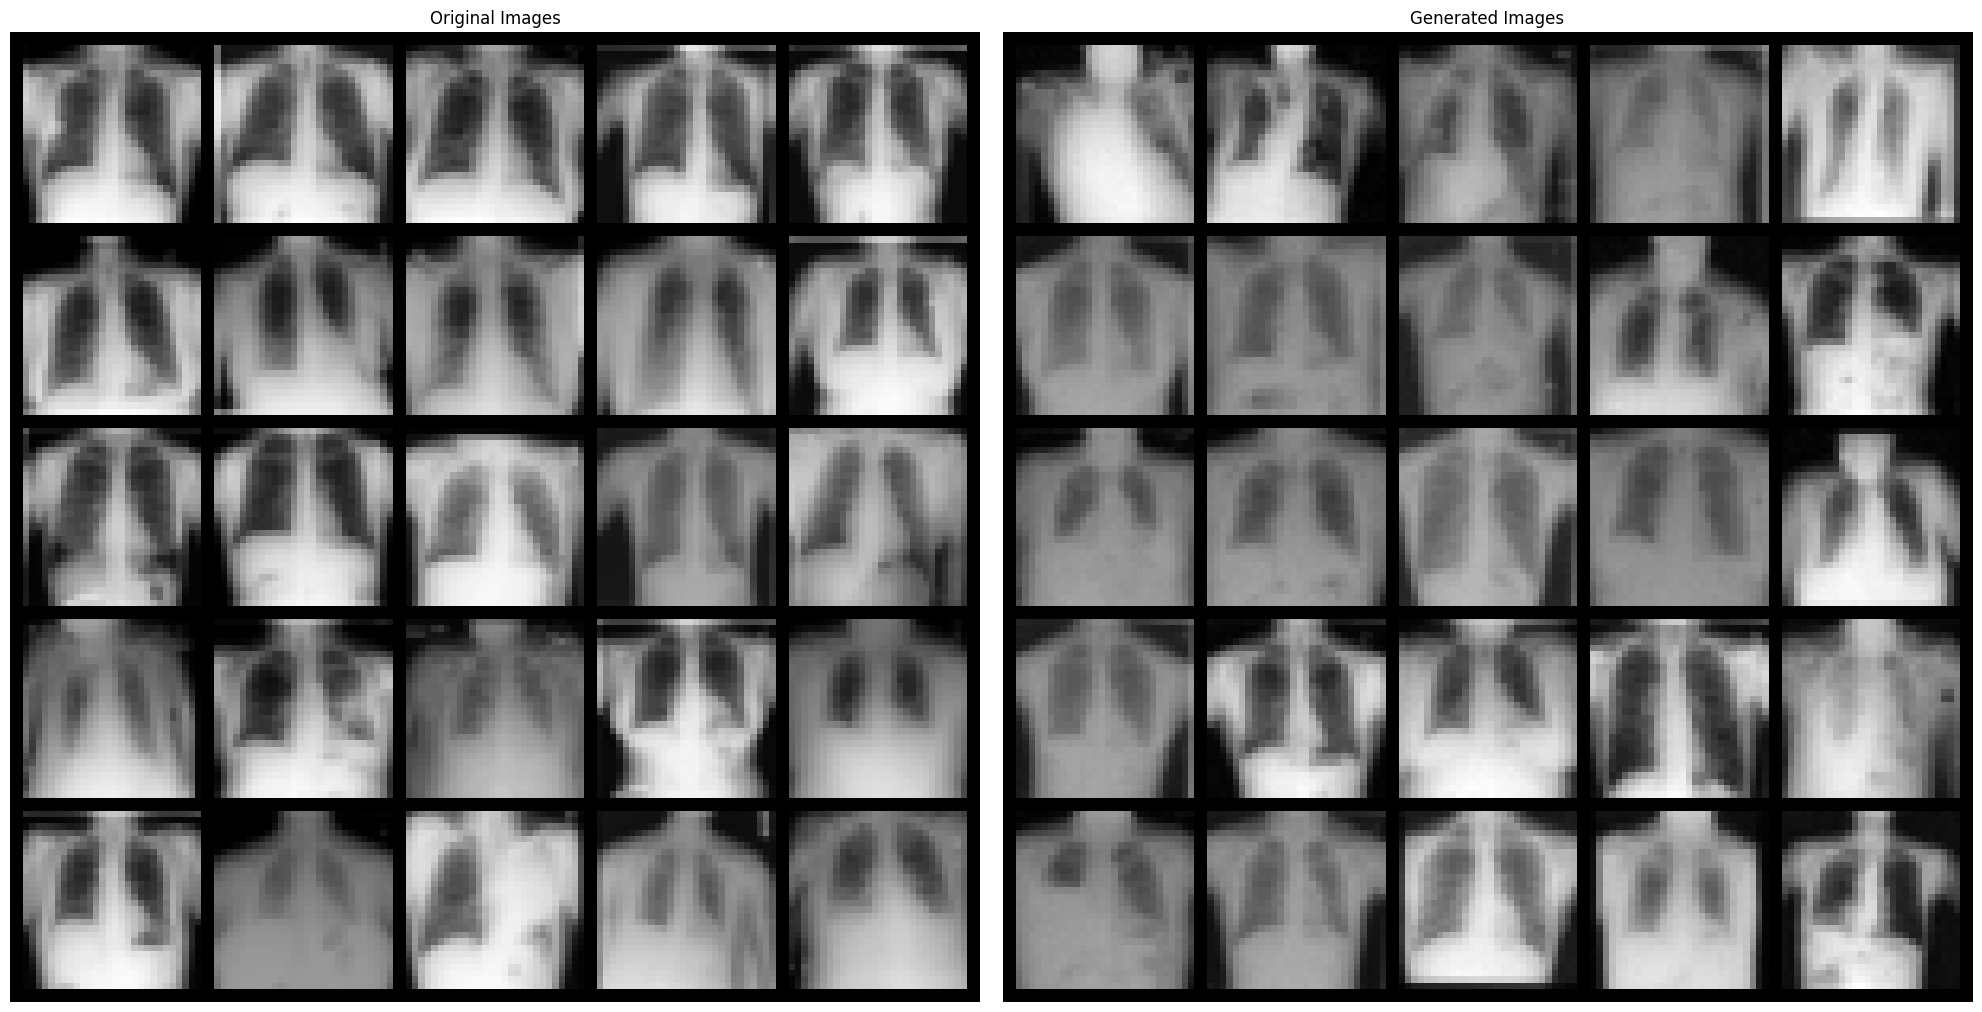

In [73]:
import torchvision
original_samples, _ = next(iter(test_loader))
visualize_samples_grid(original_samples, generated_samples)

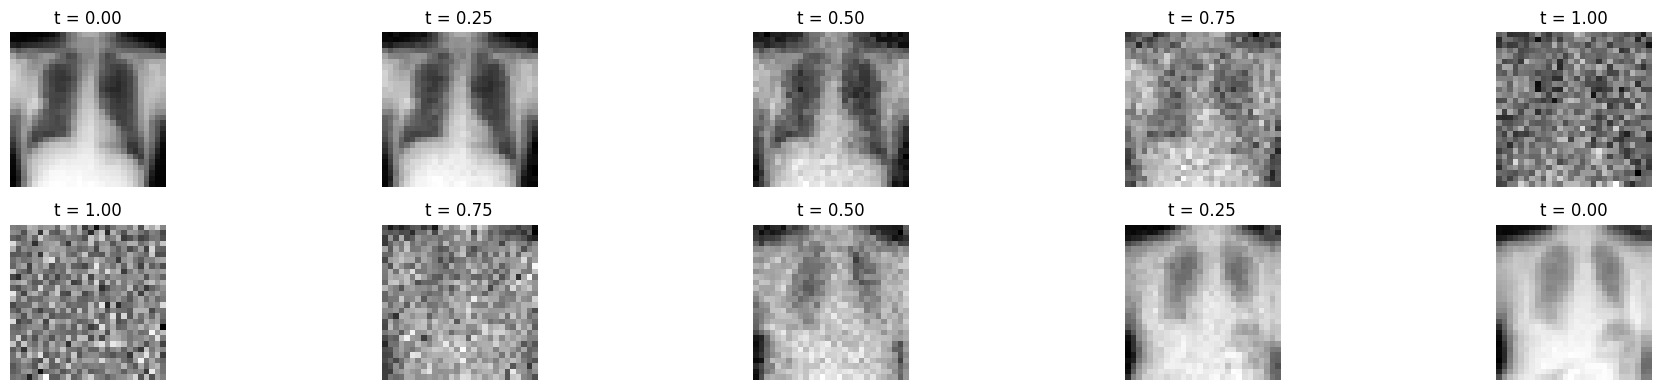

In [74]:
# diffusion process
original_image = original_samples[0].unsqueeze(0).to(device)
visualize_diffusion_process(model, sde, original_image, device)

In [82]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

inception = inception_v3(pretrained=True, transform_input=False).eval().to(device)

def calculate_inception_score(images, splits=10):
    N = images.shape[0]
    images = images.repeat(1, 3, 1, 1)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    batch_size = 32
    n_batches = N // batch_size + (1 if N % batch_size != 0 else 0)
    
    preds = []
    for i in range(n_batches):
        batch = images[i*batch_size: (i+1)*batch_size].to(device)
        with torch.no_grad():
            pred = F.softmax(inception(batch), dim=1)
        preds.append(pred.cpu())
    
    preds = torch.cat(preds, dim=0)
    
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = torch.mean(part, dim=0)
        scores = torch.sum(part * (torch.log(part) - torch.log(py)), dim=1)
        split_scores.append(torch.exp(torch.mean(scores)).item())

    return np.mean(split_scores), np.std(split_scores)

def extract_features(images):
    N = images.shape[0]
    images = images.repeat(1, 3, 1, 1)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    batch_size = 32
    n_batches = N // batch_size + (1 if N % batch_size != 0 else 0)
    
    features = []
    for i in range(n_batches):
        batch = images[i*batch_size: (i+1)*batch_size].to(device)
        with torch.no_grad():
            feat = inception(batch)
        features.append(feat.cpu())
    
    features = torch.cat(features, dim=0).numpy()
    features = features.astype(np.float64)  # 데이터 타입을 float64로 변경
    
    epsilon = 1e-6
    features -= np.mean(features, axis=0)
    features /= np.std(features, axis=0) + epsilon
    
    return features

def calculate_fid(real_features, fake_features):
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)

    diff = mu_real - mu_fake
    
    epsilon = 1e-6
    sigma_real += epsilon * np.eye(sigma_real.shape[0])
    sigma_fake += epsilon * np.eye(sigma_fake.shape[0])
    
    covmean, _ = sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    tr_covmean = np.trace(covmean)
    
    fid = (diff.dot(diff) + np.trace(sigma_real) + np.trace(sigma_fake) - 2 * tr_covmean)
    
    
    return max(fid, 0.0)  



In [83]:
# Inception Score
mean_is, std_is = calculate_inception_score(generated_samples)
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

# FID
real_features = extract_features(original_samples)
fake_features = extract_features(generated_samples)
fid_score = calculate_fid(real_features, fake_features)
print(f"FID Score: {fid_score:.4f}")

Inception Score: 1.8603 ± 0.1742
FID Score: 587.0951
